In [3]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

g, m , rho, Vb, veq = sp.symbols('g m rho V_b V_eq')

v, vc, y, ym, th, th1, th2, B, p, a, b, e, gamma = sp.symbols('v v_c y y_m theta theta_1 theta_2 B p a b e gamma')
u, uc, zeta, omega = sp.symbols('u u_c zeta omega')

In [16]:
y_u = B*u/(p**2+p*B)
ym_uc = (omega**2)*uc/(p**2+2*zeta*omega*p+omega**2)

u_u = th1*(y-uc)-th2*p*y

y_uc = -B*th1*uc/(p**2+p*(B+B*th2)-B*th1)
error = y_uc - ym_uc

uc_y = (p**2+p*(B+B*th2)-B*th1)*y/(-B*th1)
uc_ym = (p**2+2*zeta*omega*p+omega**2)*ym/(omega**2)


In [30]:
de_th1 = sp.diff(error,th1).simplify()
de_th1

-B*p*u_c*(B*(theta_2 + 1) + p)/(B*p*(theta_2 + 1) - B*theta_1 + p**2)**2

In [21]:
de_th2 = sp.diff(error,th2).simplify()
de_th2

B**2*p*theta_1*u_c/(B*p*(theta_2 + 1) - B*theta_1 + p**2)**2

In [25]:
de_th1.subs(uc, uc_y).simplify()

p*y*(B*(theta_2 + 1) + p)/(theta_1*(B*p*(theta_2 + 1) - B*theta_1 + p**2))

In [27]:
de_th2.subs(uc, uc_y).simplify()

-B*p*y/(B*p*(theta_2 + 1) - B*theta_1 + p**2)

In [28]:
error

-B*theta_1*u_c/(-B*theta_1 + p**2 + p*(B*theta_2 + B)) - omega**2*u_c/(omega**2 + 2*omega*p*zeta + p**2)

In [403]:
#constants 
ZETA = 1
OMEGA = 1

#
radius = 40/1000
g = 9.8
m = 0.01
rho = 1.225
Vb = (4/3)*np.pi*(radius**3)
v_eq=0.7979
B = 2*g*(m-rho*Vb)/(m*v_eq)
#B=2

#adaptation law
GAMMA = 0.001

#simulation params
ts = 0.05
maxt = 250
n_steps = int(maxt/ts)

def system_model(uc_i, ym_p1_i, ym_i):
    ym_p2_o = (OMEGA**2)*uc_i - 2*ZETA*OMEGA*ym_p1_i - (OMEGA**2)*ym_i
    ym_p1_o = ym_p1_i + ts*ym_p2_o
    ym_o = ym_i + ts*ym_p1_o
    
    system_model_dict = {"ym_p2":ym_p2_o,
                          "ym_p1":ym_p1_o,
                          "ym":ym_o}
    return system_model_dict

def system_sim(y_p1_i,y_i,u_i):
    y_p2_o = B*u_i - B*y_p1_i
    
    y_p1_o = y_p1_i + ts*y_p2_o
    
    y_o = y_i + ts*y_p1_o
    
    system_dict = {"y_p2":y_p2_o,
                "y_p1": y_p1_o,
                  "y": y_o}
    
    return system_dict
def controller(y_i, uc_i, y_p1_i, th1, th2):
    control_signal = th1*(y_i - uc_i) - th2*y_p1_i
    return control_signal

def Adaptation_Law_Model(y_i, ym_i, ym_p1_i, ym_p2_i,
                        theta1_p2_i, theta1_p1_i, theta1_i,
                        theta2_p2_i, theta2_p1_i, theta2_i):
    
    error = y_i - ym_i
    
    theta1_p3_o = (GAMMA*error*B/OMEGA**2)*(2*ZETA*OMEGA*ym_p1_i+ym_p2_i) - 2*ZETA*OMEGA*theta1_p2_i - (OMEGA**2)*theta1_p1_i
    theta1_p2_o = theta1_p2_i + ts*theta1_p3_o
    theta1_p1_o = theta1_p1_i + ts*theta1_p2_o
    theta1_o = theta1_i + ts*theta1_p1_o
    
    theta2_p3_o = GAMMA*error*B*ym_p1_i - 2*ZETA*OMEGA*theta2_p2_i - (OMEGA**2)*theta2_p1_i
    theta2_p2_o = theta2_p2_i + ts*theta2_p3_o
    theta2_p1_o = theta2_p1_i + ts*theta2_p2_o
    theta2_o = theta2_i + ts*theta2_p1_o
    
    result_dict = {
                   "theta1_p2": theta1_p2_o,
                   "theta1_p1": theta1_p1_o,
                   "theta1": theta1_o,
                   "theta2_p2": theta2_p2_o,
                   "theta2_p1": theta2_p1_o,
                   "theta2": theta2_o
                  }
    return result_dict

In [404]:
i = 0

#system input
uc_i = 1

#initial state of system
y_p1_i = 0
y_i = 0
u_i = 0

#initial state of model
ym_p1_i = 0
ym_i = 0

theta1_p2_i, theta1_p1_i, theta2_p2_i, theta2_p1_i = 0,0,0,0

theta1_i = -(OMEGA**2)/B
theta2_i = (2*ZETA*OMEGA)/(1+B)

# theta1_i = 0.1
# theta2_i = 0.1


y_list = []
ym_list = []
u_list = []
tc= []
error_list = []

def u_signal(t):
    function_val = np.sin(np.pi*t/30)
    if function_val >= 0:
        result = 1
    else:
        result = -1
    return result
uc = []
for i in range(int(maxt/ts)+1):
    uc.append(u_signal(i*ts))


i=0
for k in range(n_steps):
    #system
    system_results = system_sim(y_p1_i,y_i,u_i)
    y_i = system_results["y"]
    y_p1_i = system_results["y_p1"]
    
    #model
    model_results = system_model(uc_i, ym_p1_i, ym_i)
    ym_p2_i = model_results["ym_p2"]
    ym_p1_i = model_results["ym_p1"]
    ym_i = model_results["ym"]
    
    #adaptation
    adapt_val = Adaptation_Law_Model(y_i, ym_i, ym_p1_i, ym_p2_i,
                        theta1_p2_i, theta1_p1_i, theta1_i,
                        theta2_p2_i, theta2_p1_i, theta2_i)
    theta1_p2_i, theta1_p1_i, theta1_i = adapt_val["theta1_p2"], adapt_val["theta1_p1"], adapt_val["theta1"]
    theta2_p2_i, theta2_p1_i, theta2_i = adapt_val["theta2_p2"], adapt_val["theta2_p1"], adapt_val["theta2"]
    
    u_i =  controller(y_i, uc_i, y_p1_i, theta1_i, theta2_i)
    uc_i = uc[i]
    #uc_i = 1
    y_list.append(y_i)
    u_list.append(u_i)
    ym_list.append(ym_i)
    error_list.append(y_i-ym_i)
    
    tc.append(i)
    i = i+1
    


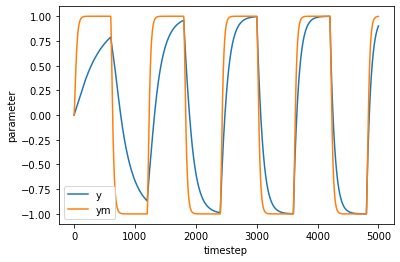

In [405]:
start_idx = 0
end_idx = int(maxt/ts)
plt.plot(tc[start_idx:end_idx], y_list[start_idx:end_idx], label = "y")
plt.plot(tc[start_idx:end_idx], ym_list[start_idx:end_idx], label = "ym")
#plt.plot(tc[start_idx:end_idx], error_list[start_idx:end_idx], label = "y - ym")
plt.xlabel("timestep")
plt.ylabel("parameter")
plt.legend()

In [133]:
def MRAS_system_sim(y_i,u_i):
    y_p1_o = -a*y_i + b*u_i
    y_o = y_i + ts*y_p1_o
    
    system_dict = {"y_p1": y_p1_o,
                  "y": y_o}
    
    return system_dict

def controller(theta1_i, uc_i, theta2_i, y_i):
    u_o = theta1_i*uc_i - theta2_i*y_i
    return u_o

def system_model(ym_i, uc_i):
    ym_p1_o = -am*ym_i + bm*uc_i
    ym_o = ym_i + ts*ym_p1_o
    result_dict = {"ym_p1":ym_p1_o,
                   "ym":ym_o}
    return result_dict
    

def Adaptation_Law(theta1_i, theta1_p1_i,
                 theta2_i, theta2_p1_i,
                 uc_i, y_i, ym_i):
    
    #error
    error = y_i - ym_i
    
    #theta1
    theta1_p2_o = -am*theta1_p1_i - gamma*am*uc_i*error
    theta1_p1_o = theta1_p1_i + ts*theta1_p2_o
    theta1_o = theta1_i + ts*theta1_p1_o
    
    #theta2
    theta2_p2_o = -am*theta2_p1_i + gamma*am*y_i*error
    theta2_p1_o = theta2_p1_i + ts*theta2_p2_o
    theta2_o = theta2_i + ts*theta2_p1_o
    
    result_dict = {
               "theta1_p1": theta1_p1_o,
               "theta1": theta1_o,
               
               "theta2_p1": theta2_p1_o,
               "theta2": theta2_o, 
              }
    return result_dict

#params
#from MRAS example
a = 1
b = 0.5
am = 2
bm = 2

maxt = 200
ts = 0.1
n_steps = int(maxt/ts)

def u_signal(t):
    function_val = np.sin(np.pi*t/30)
    if function_val >= 0:
        result = 1
    else:
        result = -1
    return result

uc = []
for i in range(int(maxt/ts)+1):
  uc.append(u_signal(i*ts))


gamma = 1

theta1_actual = bm/b
theta2_actual = (am-a)/b

theta1_actuals = n_steps*[theta1_actual]
theta2_actuals = n_steps*[theta2_actual]


theta1 = [0.1]
theta2 = [0.1]
theta1_p1 = [0]
theta2_p1 = [0]
theta1_p2 = [0]
theta2_p2 = [0]

y = [0]
ym = [0]
y_p1 = [0]
ym_p1 = [0]
y_p2 = [0]
ym_p2 = [0]

u = []

i = 0
tc = []

theta1_i = 0.1
theta1_p1_i = 0
theta1_p2_i = 0
        
theta2_i  = 0.1
theta2_p1_i = 0
theta2_p2_i = 0
u_i = 0
uc_i = uc[0]
y_i = 0
y_p1_i = 0
ym_i = 0
ym_p1_i = 0

y_list = []
ym_list = []
u_list = []
tc= []
error_list = []

In [134]:
for k in range(n_steps):
    
    #system output
    system_values = MRAS_system_sim(y_i,u_i)
    y_i, y_p1_i = system_values["y"], system_values["y_p1"]
    
    model_values = system_model(ym_i, uc_i)
    ym_i = model_values["ym"]
    
    #controller 
    u_i = controller(theta1_i, uc_i, theta2_i, y_i)
    
    #adaptation
    MRAS_values = Adaptation_Law(theta1_i, theta1_p1_i,
                 theta2_i, theta2_p1_i,
                 uc_i, y_i, ym_i)
    
    theta1_i, theta1_p1_i  = MRAS_values["theta1"], MRAS_values["theta1_p1"]
    theta2_i,theta2_p1_i  = MRAS_values["theta2"], MRAS_values["theta2_p1"]
    
    #control input, 
    uc_i = uc[k]
    
    y_list.append(y_i)
    u_list.append(u_i)
    ym_list.append(ym_i)
    error_list.append(y_i-ym_i)
    
    tc.append(i)
    i = i+1

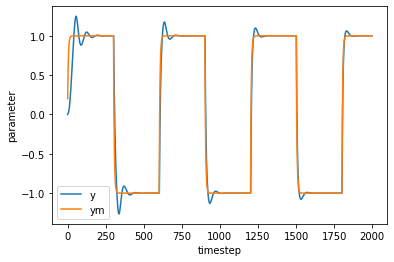

In [135]:
start_idx = 0
end_idx = int(maxt/ts)
plt.plot(tc[start_idx:end_idx], y_list[start_idx:end_idx], label = "y")
plt.plot(tc[start_idx:end_idx], ym_list[start_idx:end_idx], label = "ym")
#plt.plot(tc[start_idx:end_idx], error_list[start_idx:end_idx], label = "y - ym")
plt.xlabel("timestep")
plt.ylabel("parameter")
plt.legend()